Readme

这部分代码为神经网络模型的实现过程，首先沿用前文所提及的数据分析与欠采样处理结果，在获得new_df之后根据该数据库进行模型训练，对应调出神经网络与正则化需要的包，依次迭代并根据可视化呈现结果选择最佳模型。最终模型确立之后，人工搭建合适的可视化函数，依次呈现ROC曲线与混淆矩阵。

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, TruncatedSVD
import matplotlib.patches as mpatches
import time

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import collections


from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from imblearn.pipeline import make_pipeline as imbalanced_make_pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
from imblearn.metrics import classification_report_imbalanced
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report
from collections import Counter
from sklearn.model_selection import KFold, StratifiedKFold
import warnings
warnings.filterwarnings("ignore")

# 导入数据

In [7]:
df = pd.read_csv('creditcard.csv')
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [8]:
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.487313e-15,-5.556467e-16,1.213481e-16,-2.406331e-15,...,1.654067e-16,-3.568593e-16,2.578648e-16,4.473266e-15,5.340915e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [9]:
df.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

数据集不平衡，需要过采样或欠采样。

# 数据预处理

## 标准化
（对Time和Amount两列）

In [10]:
from sklearn.preprocessing import StandardScaler, RobustScaler

rob_scaler = RobustScaler()
df['scaled_amount'] = rob_scaler.fit_transform(df['Amount'].values.reshape(-1,1))
df['scaled_time'] = rob_scaler.fit_transform(df['Time'].values.reshape(-1,1))
df.drop(['Time','Amount'], axis=1, inplace=True)

In [11]:
scaled_amount = df['scaled_amount']
scaled_time = df['scaled_time']
df.drop(['scaled_amount', 'scaled_time'], axis=1, inplace=True)
df.insert(0, 'scaled_amount', scaled_amount)
df.insert(1, 'scaled_time', scaled_time)
df.head()

,scaled_amount,scaled_time,V1,V2,V3,V4,V5,V6,V7,V8,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
0,1.783274,-0.994983,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,...,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0
1,-0.269825,-0.994983,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,...,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0
2,4.983721,-0.994972,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,...,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0
3,1.418291,-0.994972,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,...,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0
4,0.670579,-0.994960,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,...,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0


## 分割测试集和训练集

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit

X = df.drop('Class', axis=1)
y = df['Class']

sss = StratifiedKFold(n_splits=5, random_state=None, shuffle=False)

for train_index, test_index in sss.split(X, y):
    print("Train:", train_index, "Test:", test_index)
    original_Xtrain, original_Xtest = X.iloc[train_index], X.iloc[test_index]
    original_ytrain, original_ytest = y.iloc[train_index], y.iloc[test_index]

# Turn into an array
original_Xtrain = original_Xtrain.values
original_Xtest = original_Xtest.values
original_ytrain = original_ytrain.values
original_ytest = original_ytest.values

# See if both the train and test label distribution are similarly distributed
train_unique_label, train_counts_label = np.unique(original_ytrain, return_counts=True)
test_unique_label, test_counts_label = np.unique(original_ytest, return_counts=True)
print('-' * 100)

print('Label Distributions: \n')
print(train_counts_label/ len(original_ytrain))
print(test_counts_label/ len(original_ytest))

Train: [ 30473  30496  31002 ... 284804 284805 284806] Test: [    0     1     2 ... 57017 57018 57019]
Train: [     0      1      2 ... 284804 284805 284806] Test: [ 30473  30496  31002 ... 113964 113965 113966]
Train: [     0      1      2 ... 284804 284805 284806] Test: [ 81609  82400  83053 ... 170946 170947 170948]
Train: [     0      1      2 ... 284804 284805 284806] Test: [150654 150660 150661 ... 227866 227867 227868]
Train: [     0      1      2 ... 227866 227867 227868] Test: [212516 212644 213092 ... 284804 284805 284806]
----------------------------------------------------------------------------------------------------
Label Distributions: 

[0.99827076 0.00172924]
[0.99827952 0.00172048]


## 随机欠采样

In [13]:
df = df.sample(frac=1)
fraud_df = df.loc[df['Class'] == 1]
non_fraud_df = df.loc[df['Class'] == 0][:492]

normal_distributed_df = pd.concat([fraud_df, non_fraud_df])
new_df = normal_distributed_df.sample(frac=1, random_state=42)

new_df.head()

,scaled_amount,scaled_time,V1,V2,V3,V4,V5,V6,V7,V8,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
262443,-0.293579,0.890342,2.014978,-0.037888,-0.987301,0.313960,-0.059304,-0.923751,0.136860,-0.239055,...,-0.166804,-0.222740,-0.503604,0.330417,0.099293,-0.313609,0.170102,-0.069054,-0.067594,0
106679,2.868721,-0.171771,-0.440095,1.137239,-3.227080,3.242293,-2.033998,-1.618415,-3.028013,0.764555,...,0.895841,0.764187,-0.275578,-0.343572,0.233085,0.606434,-0.315433,0.768291,0.459623,1
237376,-0.293440,0.758021,0.290496,0.982292,-0.125965,0.995296,0.706589,-1.096845,1.134729,-0.233423,...,-0.226314,0.044844,0.087113,-0.236390,-0.083655,0.359686,-0.399813,-0.047320,-0.089082,0
128479,0.530986,-0.070102,-4.312479,1.886476,-2.338634,-0.475243,-1.185444,-2.112079,-2.122793,0.272565,...,-0.718706,0.550541,-0.067870,-1.114692,0.269069,-0.020572,-0.963489,-0.918888,0.001454,1
18466,-0.297911,-0.648104,1.102804,2.829168,-3.932870,4.707691,2.937967,-1.800904,1.672734,-0.300240,...,-0.030880,-0.106994,-0.250050,-0.521627,-0.448950,1.291646,0.516327,0.009146,0.153318,1


In [14]:
# New_df is from the random undersample data (fewer instances)
X = new_df.drop('Class', axis=1)
y = new_df['Class']


# T-SNE Implementation
t0 = time.time()
X_reduced_tsne = TSNE(n_components=2, random_state=42).fit_transform(X.values)
t1 = time.time()
print("T-SNE took {:.2} s".format(t1 - t0))

# PCA Implementation
t0 = time.time()
X_reduced_pca = PCA(n_components=2, random_state=42).fit_transform(X.values)
t1 = time.time()
print("PCA took {:.2} s".format(t1 - t0))

# TruncatedSVD
t0 = time.time()
X_reduced_svd = TruncatedSVD(n_components=2, algorithm='randomized', random_state=42).fit_transform(X.values)
t1 = time.time()
print("Truncated SVD took {:.2} s".format(t1 - t0))

T-SNE took 3.1 s
PCA took 0.014 s
Truncated SVD took 0.005 s


In [29]:
# Our data is already scaled we should split our training and test sets
from sklearn.model_selection import train_test_split
import keras
from keras import backend as K
from keras.models import Sequential
from keras.layers import Activation
from keras.layers.core import Dense
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy
from tensorflow.keras.datasets.mnist import load_data
from matplotlib import pyplot as plt
import numpy as np
from numpy import asarray
from numpy import unique
from numpy import argmax
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPool2D
from tensorflow.keras.layers import Flatten
import random
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Dropout
from tensorflow.keras.utils import plot_model, to_categorical
# This is explicitly used for undersampling.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [30]:
# Turn the values into an array for feeding the classification algorithms.
X_train = X_train.values
X_test = X_test.values
y_train = y_train.values
y_test = y_test.values

In [31]:
n_inputs = X_train.shape[1]
n_classes = len(unique(y_train))
in_shape = X_train.shape[1:]
in_shape

(30,)

In [32]:
# define model
# model = Sequential()
# model.add(Flatten())
# model.add(Dense(units=n_inputs, activation='relu'))
# model.add(Dense(units=100, activation='relu'))
# model.add(Dense(units =100, activation = 'relu'))
# model.add(Dense(units=n_classes, activation='softmax'))
# model.compile(optimizer='sgd', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
# model.fit(X_train, y_train, validation_split=0.2, batch_size=25, epochs=20, shuffle=True, verbose=2)
y_train, y_test = to_categorical(y_train), to_categorical(y_test)

model = Sequential()
model.add(Flatten())
model.add(Dense(units=n_inputs, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Dense(units=100, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Dense(units =100, activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Dense(units=n_classes, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.fit(X_train, y_train, validation_split=0.2, batch_size=25, epochs=300, shuffle=True, verbose=2)
# evaluate the model on training set and test set

loss, acc = model.evaluate(X_train, y_train, verbose=0)
print('Test Accuracy on the training set: %.3f' % acc)
loss, acc = model.evaluate(X_test, y_test, verbose=0)
print('Test Accuracy on the test set: %.3f' % acc)

model.summary()

Epoch 1/300
26/26 - 2s - loss: 0.6294 - accuracy: 0.7520 - val_loss: 0.4034 - val_accuracy: 0.9051 - 2s/epoch - 61ms/step
Epoch 2/300
26/26 - 0s - loss: 0.3799 - accuracy: 0.8633 - val_loss: 0.3129 - val_accuracy: 0.9304 - 58ms/epoch - 2ms/step
Epoch 3/300
26/26 - 0s - loss: 0.3131 - accuracy: 0.8951 - val_loss: 0.2590 - val_accuracy: 0.9367 - 58ms/epoch - 2ms/step
Epoch 4/300
26/26 - 0s - loss: 0.3078 - accuracy: 0.8967 - val_loss: 0.2242 - val_accuracy: 0.9367 - 61ms/epoch - 2ms/step
Epoch 5/300
26/26 - 0s - loss: 0.2735 - accuracy: 0.9078 - val_loss: 0.1800 - val_accuracy: 0.9494 - 63ms/epoch - 2ms/step
Epoch 6/300
26/26 - 0s - loss: 0.2613 - accuracy: 0.9141 - val_loss: 0.1507 - val_accuracy: 0.9494 - 60ms/epoch - 2ms/step
Epoch 7/300
26/26 - 0s - loss: 0.2505 - accuracy: 0.9157 - val_loss: 0.1409 - val_accuracy: 0.9557 - 57ms/epoch - 2ms/step
Epoch 8/300
26/26 - 0s - loss: 0.2516 - accuracy: 0.9157 - val_loss: 0.1390 - val_accuracy: 0.9557 - 58ms/epoch - 2ms/step
Epoch 9/300
26/26

In [29]:
import itertools
from sklearn.metrics import confusion_matrix
# Create a confusion matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=14)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [30]:
model_predict=model.predict(X_test,batch_size=200,verbose=0)
model_fraud_predictions = np.argmax(model_predict,axis=1)
model_fraud_predictions

array([0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1,
       1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1,
       0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0,
       1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0,
       1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0,
       1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0], dtype=int64)

Confusion matrix, without normalization
[[94  3]
 [ 9 84]]


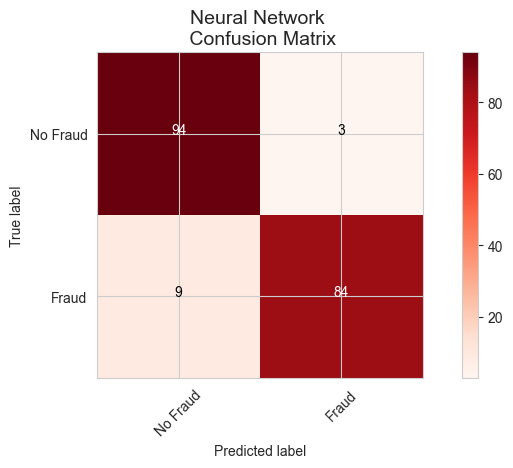

In [31]:
undersample_cm = confusion_matrix(y_test, model_fraud_predictions)
actual_cm = confusion_matrix(original_ytest, original_ytest)
labels = ['No Fraud', 'Fraud']

fig = plt.figure(figsize=(16,8))

fig.add_subplot(221)
plot_confusion_matrix(undersample_cm, labels, title="Neural Network \n Confusion Matrix", cmap=plt.cm.Reds)



In [ ]:
# Use GridSearchCV to find the best parameters.
from sklearn.model_selection import GridSearchCV


# Logistic Regression
log_reg_params = {"penalty": ['l1', 'l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}



grid_log_reg = GridSearchCV(LogisticRegression(), log_reg_params)
grid_log_reg.fit(X_train, y_train)
# We automatically get the logistic regression with the best parameters.
log_reg = grid_log_reg.best_estimator_

knears_params = {"n_neighbors": list(range(2,5,1)), 'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']}

grid_knears = GridSearchCV(KNeighborsClassifier(), knears_params)
grid_knears.fit(X_train, y_train)
# KNears best estimator
knears_neighbors = grid_knears.best_estimator_

# Support Vector Classifier
svc_params = {'C': [0.5, 0.7, 0.9, 1], 'kernel': ['rbf', 'poly', 'sigmoid', 'linear']}
grid_svc = GridSearchCV(SVC(), svc_params)
grid_svc.fit(X_train, y_train)

# SVC best estimator
svc = grid_svc.best_estimator_

# DecisionTree Classifier
tree_params = {"criterion": ["gini", "entropy"], "max_depth": list(range(2,4,1)),
              "min_samples_leaf": list(range(5,7,1))}
grid_tree = GridSearchCV(DecisionTreeClassifier(), tree_params)
grid_tree.fit(X_train, y_train)

# tree best estimator
tree_clf = grid_tree.best_estimator_

In [33]:
from sklearn.metrics import roc_curve,auc
from sklearn.model_selection import cross_val_predict

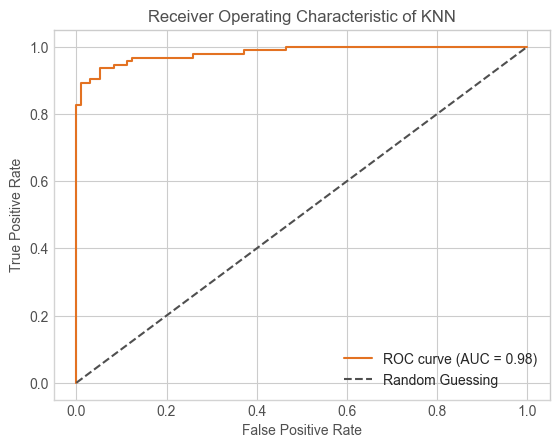

In [37]:
fpr, tpr, thresholds = roc_curve(y_test,model_predict[:,1])

# 计算AUC
roc_auc = auc(fpr, tpr)

# 自定义贝恩公司主题配色方案
bain_colors = {
    'blue': '#0067B3',
    'orange': '#E37222',
    'gray': '#7F7F7F',
    'light_gray': '#D3D3D3',
    'dark_gray': '#4F4F4F'
}

# 设置图形样式
plt.style.use('seaborn-whitegrid')

# 绘制ROC曲线
plt.plot(fpr, tpr, color=bain_colors['orange'], label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color=bain_colors['dark_gray'], linestyle='--', label='Random Guessing')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic of KNN')
plt.legend(loc='lower right')

# 设置坐标轴标签和标题颜色
ax = plt.gca()
ax.xaxis.label.set_color(bain_colors['dark_gray'])
ax.yaxis.label.set_color(bain_colors['dark_gray'])
ax.title.set_color(bain_colors['dark_gray'])

# 设置坐标轴线颜色
ax.spines['bottom'].set_color(bain_colors['light_gray'])
ax.spines['left'].set_color(bain_colors['light_gray'])

# 设置刻度和刻度标签颜色
ax.tick_params(axis='x', colors=bain_colors['dark_gray'])
ax.tick_params(axis='y', colors=bain_colors['dark_gray'])

plt.show()
